# Tutorial 4: Analysis and Post-processing

This notebook covers the basics of data analysis and post-processing using Dedalus.

First, we'll import the public interface and suppress some of the logging messages:

In [1]:
from dedalus import public as de
import numpy as np
import matplotlib.pyplot as plt

de.logging_setup.rootlogger.setLevel('ERROR')
%matplotlib inline

## 4.1: Analysis

Dedalus includes a framework for evaluating and saving arbitrary analysis tasks while an initial value problem is running.  To get started, let's setup the KdV-Burgers problem from the previous tutorial.

In [2]:
# Create basis and domain
x_basis = de.Chebyshev('x', 1024, interval=(-2, 6), dealias=3/2)
domain = de.Domain([x_basis], np.float64)

# Create problem
problem = de.IVP(domain, variables=['u', 'ux', 'uxx'])
problem.meta[:]['x']['dirichlet'] = True
problem.parameters['a'] = 2e-4
problem.parameters['b'] = 1e-4
problem.add_equation("dt(u) - a*dx(ux) - b*dx(uxx) = -u*ux")
problem.add_equation("ux - dx(u) = 0")
problem.add_equation("uxx - dx(ux) = 0")
problem.add_bc('left(u) = 0')
problem.add_bc('left(ux) = 0')
problem.add_bc('right(ux) = 0')

# Build solver
solver = problem.build_solver(de.timesteppers.RK443)
solver.stop_sim_time = np.inf
solver.stop_wall_time = np.inf
solver.stop_iteration = 1000

# Reference local grid and state fields
x = domain.grid(0)
u = solver.state['u']
ux = solver.state['ux']
uxx = solver.state['uxx']

# Setup smooth triangle with support in (-1, 1)
n = 20
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*x)**2) / (2*n)
u.differentiate('x', out=ux)
ux.differentiate('x', out=uxx)

<Field 4732662728>

### Analysis handlers

The explicit evaluation of analysis tasks during timestepping is controlled by the `solver.evaluator` object.  Various handler objects are attached to the evaluator, and control when the evaluator computes their own set of tasks and what happens to the resulting data.

For example, an internal `SystemHandler` object directs the evaluator to evaluate the RHS expressions on every iteration, and uses the data for the explicit part of the timestepping algorithm.

For simulation analysis, the most useful handler is the `FileHandler`, which regularly computes tasks and writes the data to HDF5 files.  When setting up a file handler, you specify the name/path for the output directory/files, as well as the cadence at which you want the handler's tasks to be evaluated.  This cadence can be in terms of any combination of 
* simulation time, specified with `sim_dt`
* wall time, specified with `wall_dt`
* iteration number, specified with `iter`

To limit file sizes, the output from a file handler is split up into different sets over time, each containing some number of writes that can be limited with the `max_writes` keyword when the file handler is constructed.

Let's setup a file handler to be evaluated every few iterations.

In [3]:
analysis = solver.evaluator.add_file_handler('analysis', iter=5, max_writes=100)

You can add an arbitrary number of file handlers to save different sets of tasks at different cadences and to different files.

### Analysis tasks

Analysis tasks are added to a given handler using the `add_task` method.  Tasks are entered in plain text, and parsed using the same namespace that is used for equation entry.  For each task, you can additionally specify the output layout and scaling factors.  

Let's add tasks for tracking the first and second moments of the solution.

In [4]:
analysis.add_task("integ(u,'x')", layout='g', name='<u>')
analysis.add_task("integ(u**2,'x')", layout='g', name='<uu>')

For checkpointing, you can also simply specify that all of the state variables should be saved.

In [5]:
analysis.add_system(solver.state, layout='g')

We can now run the simulation just as in the previous tutorial, but without needing to manually save any data during the main loop.

In [6]:
import time

# Main loop
dt = 1e-2
start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 100 == 0:
        print('Completed iteration {}'.format(solver.iteration))
end_time = time.time()
print('Runtime:', end_time-start_time)

Completed iteration 100
Completed iteration 200
Completed iteration 300
Completed iteration 400
Completed iteration 500
Completed iteration 600
Completed iteration 700
Completed iteration 800
Completed iteration 900
Completed iteration 1000
Runtime: 7.432521104812622


## 4.2: Post-processing

### File arrangement

By default, the output files for each file handler are arranged as follows:
1. A base folder taking the name that was specified when the file handler was constructed, e.g. `analysis/`.
2. Within the base folder are subfolders for each set of outputs, with the same name plus a set number, e.g. `analysis_s0/`.
3. Within each set subfolder are HDF5 files for each process, with the same name plus a process number, e.g. `analysis_s0_p1.h5`.

Let's take a look at the output files from our example problem.  We should see two sets (1000 total iterations, 5 iteration cadence, 100 writes per file) and data from one process.

In [7]:
import subprocess
print(subprocess.check_output("find analysis", shell=True).decode())

analysis
analysis/analysis_s1
analysis/analysis_s1/analysis_s1_p0.h5
analysis/analysis_s2
analysis/analysis_s2/analysis_s2_p0.h5



### Merging output files

By default, each process writes its local portion of the analysis tasks to its own file, but often it is substantially easier to deal with the global dataset.  The distributed process files can be easily merged into a global file for each set using the `merge_process_files` function from the `dedalus.tools.post` module.

Since we ran this problem serially, here this will essentially just perform a copy of the root process file, but we'll do the merge for illustrative purposes, anyways.

In [8]:
from dedalus.tools import post
post.merge_process_files("analysis", cleanup=True)

After the merge, we see that instead of a subfolder and process files for each output set, we have a single global set file for each output set.

In [9]:
import subprocess
print(subprocess.check_output("find analysis", shell=True).decode())

analysis
analysis/analysis_s1.h5
analysis/analysis_s2.h5



For some types of analysis, it's additionally convenient to merge the output sets together into a single file that's global in space and time, which can be done with the `merge_sets` function.  

**Note**: this can generate very large files, so it's not recommended for analysis that is simply slicing over time, e.g. plotting snapshots of an analysis task at different times.  However, if you want to explicitly plot a quantity versus time, instead of slicing over time, it can be useful.

In [10]:
import pathlib
set_paths = list(pathlib.Path("analysis").glob("analysis_s*.h5"))
post.merge_sets("analysis/analysis.h5", set_paths, cleanup=True)

Now we see that the two sets have been merged into a single file.

In [11]:
import subprocess
print(subprocess.check_output("find analysis", shell=True).decode())

analysis
analysis/analysis.h5



### Handling data

Each HDF5 file contains a "tasks" group containing a dataset for each task assigned to the file handler.  The first dimension of the dataset is time,  and the subsequent dimensions are the spatial dimensions of the output field.

The HDF5 datasets are self-describing, with dimensional scales attached to each axis.  For the first axis, these include the simulation time, wall time, iteration, and write number.  The scales indicate grid points or mode numbers for the spatial axes, based on the task layout.  See the [h5py docs](http://docs.h5py.org/en/latest/) for more details.

Let's open up the merged analysis file and plot time series of the moments.  We expect the first moment (momentum) to be conserved through the simulation, while the second moment (kinetic energy) should decay due to dissipation in the shock.

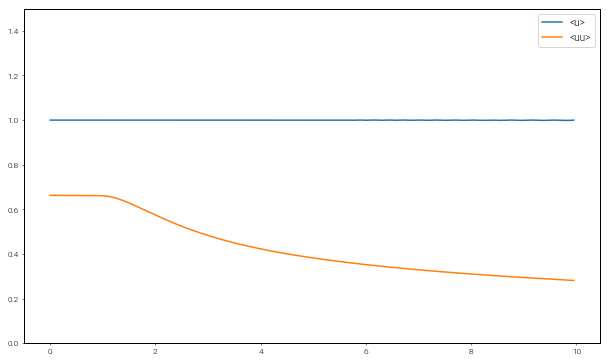

In [12]:
import h5py

fig = plt.figure(figsize=(10, 6))
with h5py.File("analysis/analysis.h5", mode='r') as file:
    u1 = file['tasks']['<u>']
    u2 = file['tasks']['<uu>']
    t = file['scales']['sim_time']
    plt.plot(t, u1, label="<u>")
    plt.plot(t, u2, label="<uu>")
    plt.ylim(0, 1.5)
    plt.legend(loc='upper right', fontsize=10)

We can also pass datasets, like fields, to the plotting helper functions in the `plot_tools` module.

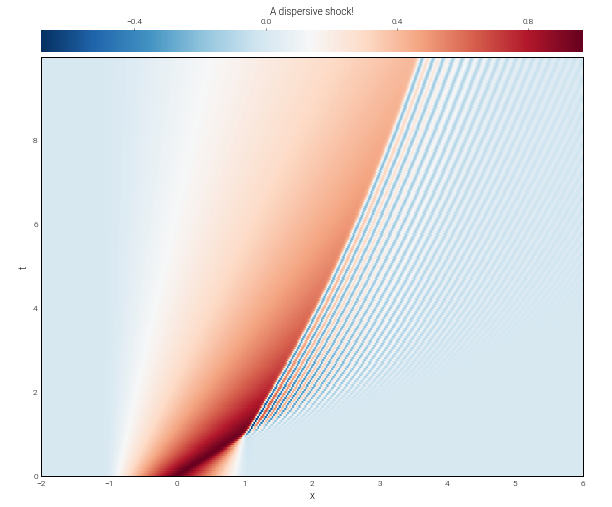

In [13]:
from dedalus.extras import plot_tools

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

with h5py.File("analysis/analysis.h5", mode='r') as file:
    u = file['tasks']['u']
    plot_tools.plot_bot_2d(u, title="A dispersive shock!", transpose=True, axes=ax)

Finally, let's cleanup the analysis files we created.

In [14]:
import shutil
shutil.rmtree('analysis')